## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import cv2
from tqdm import tqdm
import seaborn as sns
from keras.optimizers import Adam,SGD
import os.path
from keras.losses import categorical_crossentropy
#Module to print colourful statements
from termcolor import colored
%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
# project_path = "/gdrive/My Drive/Colab Notebooks/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile

def fileunzip(file_name):
    with ZipFile(file_name, 'r') as z:
        z.extractall()
        print('{} extracted successfully.!'.format(file_name))

fileunzip('train.zip')

train.zip extracted successfully.!


Repeat the same step for test.zip

In [0]:
fileunzip('test.zip')

test.zip extracted successfully.!


Repeat the same step for sample_submission.csv.zip

In [0]:
fileunzip('sample_submission.csv.zip')

sample_submission.csv.zip extracted successfully.!


Repeat the same step for labels.csv.zip

In [0]:
fileunzip('labels.csv.zip')

labels.csv.zip extracted successfully.!


After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
df=pd.read_csv('labels.csv')

### Print the count of each category of Dogs given in the dataset



In [0]:
df['breed'].value_counts().head(10)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

### Get one-hot encodings of labels

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['Label']=le.fit_transform(df['breed'])

In [0]:
df.groupby(['breed','Label']).count().head()

,,id
breed,Label,
affenpinscher,0,80
afghan_hound,1,116
african_hunting_dog,2,86
airedale,3,107
american_staffordshire_terrier,4,74


<Figure size 1440x739.44 with 0 Axes>

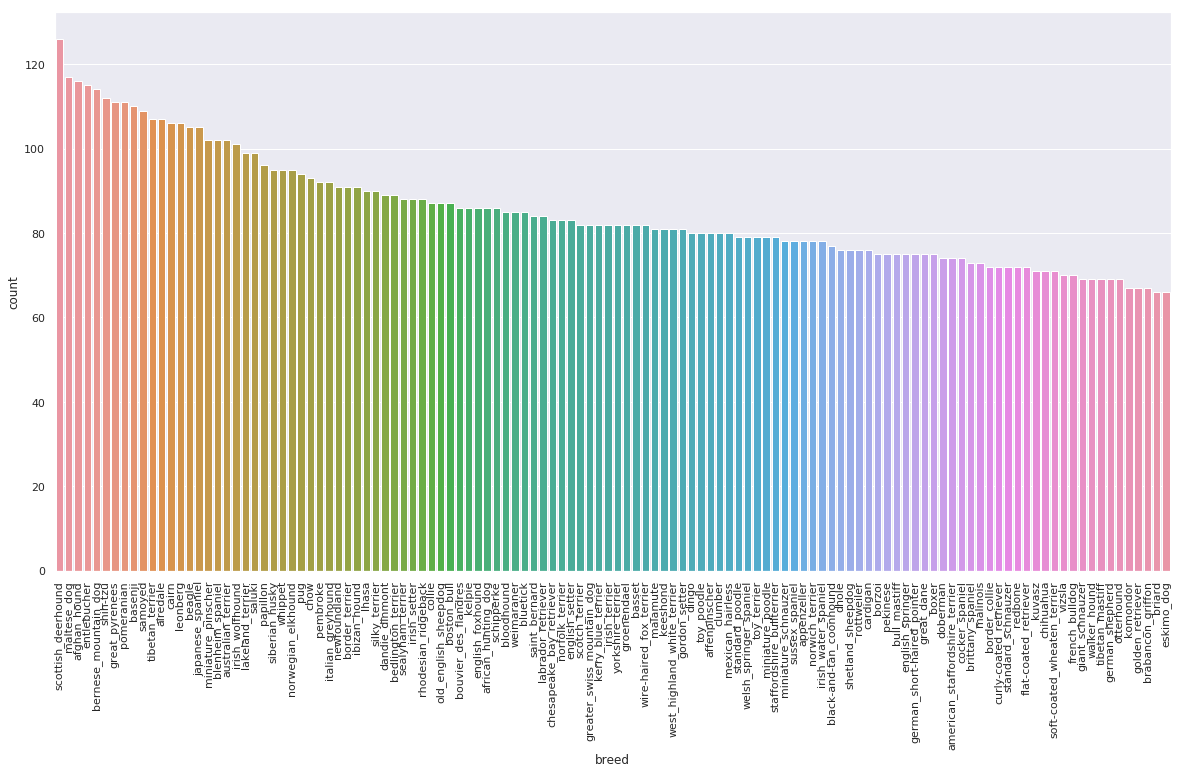

<Figure size 1440x739.44 with 0 Axes>

In [0]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20.0,10.27)})
ax = sns.countplot(x="breed", data=df,order = df['breed'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.figure()


## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
X = []
Y = []
img_rows=128
img_cols=128
for f,img in tqdm(df[['id','Label']].values): # f for format ,jpg
    cls=img
    img = cv2.imread('train/{}.jpg'.format(f),1)
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    X.append(img_resize)
    Y.append(cls)

# Save the array to the local drive for further reference
X= np.array(X)
np.save('Dog_Breed_X.npy', X)

100%|██████████| 10222/10222 [00:00<00:00, 637818.74it/s]


In [0]:
X = np.load('Dog_Breed_X.npy')

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
from keras.utils import np_utils
X=X.reshape(X.shape[0],img_rows,img_cols,3).astype('float32')
Number, height ,width, channels=X.shape
X/=255
Y1=np_utils.to_categorical(Y,len(np.unique(Y)))
print('X has {} of Images, each image is of height {} and width {} and {} channels'.format(Number, height ,width, channels))
Records, Classes=Y1.shape
print('Y has {} of Records and {} classes'.format(Records, Classes))

X has 10222 of Images, each image is of height 128 and width 128 and 3 channels
Y has 10222 of Records and 120 classes


### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.20, random_state=42,stratify=Y1)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
import pandas as pd
test_img=pd.read_csv('sample_submission.csv')

Run the below code to load the test image files in x_test_feature

In [0]:
x_test_feature = []
i = 0 # initialisation
error=[]
img_rows=128
img_cols=128

for f in tqdm(test_img['id'].values): # f for format ,jpg
    try:
        img=cv2.imread('test/{}.jpg'.format(f), 0)
        img_resize=cv2.resize(img, (img_rows,img_cols))
        x_test_feature.append(img_resize)

    except Exception as e:
        error.append(f)

100%|██████████| 10357/10357 [54:06<00:00,  2.27it/s]


Normalize the test data and convert it into 4 dimensions

In [0]:
# Save the array to the local drive for further reference
x_test_feature= np.array(x_test_feature)
np.save('Dog_Breed_test.npy', x_test_feature)
# x_test_feature.shape()

In [0]:
X_Test_Features=x_test_feature.reshape(x_test_feature.shape[0],img_rows,img_cols,3).astype('float32')
Number, height ,width, channels=x_test_feature.shape
x_test_feature/=255
print('x_test_feature has {} of Images, each image is of height {} and width {} and {} channels'.format(Number, height ,width, channels))

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
#Initialize the model
model = Sequential()

#Add a Convolutional Layer with 64 filters of size 5X3 and activation function as 'ReLU' 
model.add(Conv2D(64, kernel_size=(5, 3),activation='relu',input_shape=(height ,width, channels),name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (5, 3), activation='relu',name='conv_2'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25,name='drop_1'))

#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 256 units and activation function as 'ReLU'
model.add(Dense(256, activation='relu',name='dense_1'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5,name='drop_2'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(120, activation='softmax',name='dense_2'))

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 124, 126, 64)      2944      
_________________________________________________________________
conv_2 (Conv2D)              (None, 120, 124, 64)      61504     
_________________________________________________________________
max_1 (MaxPooling2D)         (None, 60, 62, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 60, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 238080)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               60948736  


### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# compile the model 
model.compile(loss = categorical_crossentropy, optimizer = optimizer, metrics=["accuracy"])
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
BS=32
EPOCHS=15

# Train the model 
model.fit(X_train, y_train, epochs = EPOCHS, batch_size= BS , validation_data=(X_test, y_test), callbacks = [early])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8177 samples, validate on 2045 samples
Epoch 1/15
8177/8177 [==============================] - 61s 7ms/step - loss: 4.8274 - acc: 0.0102 - val_loss: 4.7711 - val_acc: 0.0156
Epoch 2/15
8177/8177 [==============================] - 52s 6ms/step - loss: 4.7296 - acc: 0.0232 - val_loss: 4.7314 - val_acc: 0.0191
Epoch 3/15
8177/8177 [==============================] - 52s 6ms/step - loss: 4.2815 - acc: 0.0933 - val_loss: 4.7985 - val_acc: 0.0225
Epoch 4/15
8177/8177 [==============================] - 52s 6ms/step - loss: 3.2007 - acc: 0.2846 - val_loss: 5.4093 - val_acc: 0.0249
Epoch 5/15
8177/8177 [==============================] - 52s 6ms/step - loss: 2.1559 - acc: 0.5020 - val_loss: 6.0356 - val_acc: 0.0205
Epoch 6/15
8177/8177 [==============================] - 52s 6ms/step - loss: 1.5480 - acc: 0.6367 - val_loss: 6.8683 - val_acc: 0.0249
Epoch 7/15
8177/8177 [========================

In [0]:
Score=model.evaluate(X_test, y_test)
print('Test Accuracy',Score[1])

2045/2045 [==============================] - 3s 1ms/step
Test Accuracy 0.022493887530562348


#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
# Trying Image augumentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

model.fit_generator(aug.flow(X_train, y_train,batch_size=BS),validation_data=(X_test, y_test),steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, verbose=1)

Epoch 1/15
255/255 [==============================] - 52s 203ms/step - loss: 4.9272 - acc: 0.0092 - val_loss: 4.7846 - val_acc: 0.0103
Epoch 2/15
255/255 [==============================] - 52s 203ms/step - loss: 4.7873 - acc: 0.0109 - val_loss: 4.7785 - val_acc: 0.0103
Epoch 3/15
255/255 [==============================] - 52s 202ms/step - loss: 4.7827 - acc: 0.0110 - val_loss: 4.7785 - val_acc: 0.0103
Epoch 4/15
255/255 [==============================] - 52s 202ms/step - loss: 4.7799 - acc: 0.0102 - val_loss: 4.7775 - val_acc: 0.0122
Epoch 5/15
255/255 [==============================] - 52s 202ms/step - loss: 4.7789 - acc: 0.0113 - val_loss: 4.7768 - val_acc: 0.0122
Epoch 6/15
255/255 [==============================] - 52s 202ms/step - loss: 4.7798 - acc: 0.0127 - val_loss: 4.7764 - val_acc: 0.0122
Epoch 7/15
255/255 [==============================] - 53s 207ms/step - loss: 4.7790 - acc: 0.0099 - val_loss: 4.7761 - val_acc: 0.0122
Epoch 8/15
255/255 [==============================] - 5

In [0]:
Score=model.evaluate(X_test, y_test)
print('Test Accuracy',Score[1])

2045/2045 [==============================] - 3s 1ms/step
Test Accuracy 0.012224938875305624


### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
# Done above

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [0]:
# Done above

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
vgg16_model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,pooling='avg', input_shape=(height ,width, channels))

Print the summary of the base_model

In [0]:
vgg16_model .summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
#Adding custom Layers 
x = vgg16_model.output
# x=Flatten()(x)
# Adding the Flatten layers gives me an error, expected n_dim is 3 but got n_dim 2
x=Dropout(0.10)(x)
x=Dense(1024, activation='relu')(x)
x=Dense(256, activation='relu')(x)
predictions=Dense(120, activation='softmax')(x)

model = Model(inputs=vgg16_model.input, outputs=predictions)

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
for layer in vgg16_model.layers:
    layer.trainable = False

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_1
False
dropout_1
True
dense_1
True
dense_2
True
dense_3
True


### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# compile the model 
model.compile(loss = categorical_crossentropy, optimizer = optimizer, metrics=["accuracy"])
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
BS=128
EPOCHS=15

# Train the model 
model.fit(X_train, y_train, epochs = EPOCHS, batch_size= BS , validation_data=(X_test, y_test), callbacks = [early])

Train on 8177 samples, validate on 2045 samples
Epoch 1/15
8177/8177 [==============================] - 39s 5ms/step - loss: 4.7351 - acc: 0.0230 - val_loss: 4.5561 - val_acc: 0.0416
Epoch 2/15
8177/8177 [==============================] - 28s 3ms/step - loss: 4.3152 - acc: 0.0653 - val_loss: 4.0955 - val_acc: 0.0866
Epoch 3/15
8177/8177 [==============================] - 28s 3ms/step - loss: 3.8406 - acc: 0.1273 - val_loss: 3.7183 - val_acc: 0.1394
Epoch 4/15
8177/8177 [==============================] - 28s 3ms/step - loss: 3.5209 - acc: 0.1750 - val_loss: 3.5347 - val_acc: 0.1677
Epoch 5/15
8177/8177 [==============================] - 28s 3ms/step - loss: 3.3170 - acc: 0.2057 - val_loss: 3.4132 - val_acc: 0.1765
Epoch 6/15
8177/8177 [==============================] - 28s 3ms/step - loss: 3.1688 - acc: 0.2352 - val_loss: 3.3353 - val_acc: 0.2024
Epoch 7/15
8177/8177 [==============================] - 28s 3ms/step - loss: 3.0530 - acc: 0.2498 - val_loss: 3.3015 - val_acc: 0.1936
Epoch 8

In [0]:
# The Training and Testing score does not go beyong 35% and 22% regardless. As cited in the website https://github.com/n-kostadinov/keras-dogbreed/blob/master/DogBreed.ipynb
# only a multi-model archietecture would give us desired results (VGG19 & Restnet 50 together)